# UNIVERSIDADE FEDERAL DE MINAS GERAIS

PROGRAMA DE POS-GRADUAÇÃO EM ENGENHARIA ELÉTRICA
EEE882 - Computação Evolucionária

>
>  **Relatório e Exercício Computacional: Função Rastrigin**
>
> ***Prof. Michel Bessani***
>

>
> **Autores:** <br />
> Augusto Custódio Vicente <br />
> Júnio Eduardo de Moraes Aquino<br />
> Vitor Campos Miguel Neves
>
> **Data:** 12/04/2024
>

1. **Observações Gerais:**

    1.1 Os exerccios devem ser resolvidos em linguagem Python e devem ser entregues nos formatos: relatorio e py notebook. <br /> &nbsp;
    1.2 Os arquivos a serem enviados pelos discentes no Moodle, devem seguir os formatos: nome_relatorio.pdf e nome_notebook.ipynb

In [1]:
# Declaração das funções e importações das bibliotecas a serem utilizadas
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Callable

## 1 Introdução
1. Existem diferentes funções¹ propostas para a avaliação de desempenho de algoritmos de otimização [1]. Neste trabalho, iremos minimizar uma função não convexa e multimodal conhecida como função Rastrigin. Ela foi proposta por Rastrigin [2] para um domínio bidimensional, conforme ilustrado na Figura 2, e posteriormente generalizada para n dimensões [3].

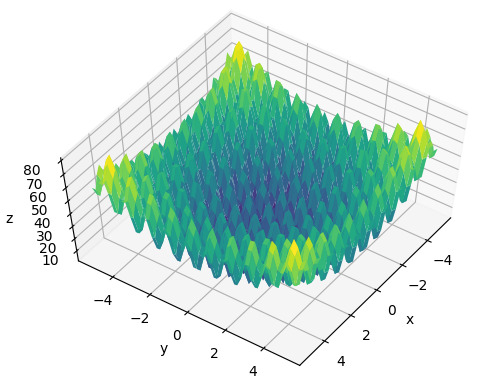
Figura 2: Função Rastrigin bidimensional

2. Deve-se desenvolver um AG para resolver o problema de minimização da função
Rastrigin para n = 10 dimensões:
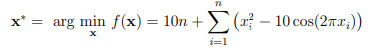
com xi ∈ [−5.12, 5.12]. O mínimo global ocorre em x ∗ = 0 com f(x ∗) = 0.



## 2 Formulação dos problemas



In [2]:
def rastrigin(x: np.ndarray) -> np.ndarray:
    """
    Computes the rastrigin function result for the provided array.

    :param np.ndarray x: Inputs for the rastrigin function, shall have shape
    (n,m) where m is the dimension used for the rastrigin function and n is the
    number of points to be evaluated.
    :return np.ndarray: Results of the rastrigin function, has shape (m,1).
    """
    if len(x.shape) == 1:
        n = x.shape[0]

        value = 10.0 * n
        value += np.sum(x** 2 - 10.0 * np.cos(2.0 * np.pi * x))
    else:
        n = x.shape[1]
        res_shape = (x.shape[0],)

        value = 10.0 * n * np.ones(res_shape)
        for i in range(0, n):
            value += x[:, i] ** 2 - 10.0 * np.cos(2.0 * np.pi * x[:, i])

    return value

## 3 Metodologia aplicada

In [3]:
def fitness(individuals: np.ndarray) -> np.ndarray:
    """
    Evaluate the fitness for the provided individuals.

    In the case of the present problem, the fitness is simply an alias for the
    rastrigin function itself.

    :param np.ndarray individuals: Individuals to evaluate the fitness. Each
    row must contain all values for a single individual.
    :return np.ndarray: Fitness for each of the provided individuals.
    """
    return rastrigin(individuals)

In [4]:
def generate_evenly_space_initial_pop(
    inf_lim: float, sup_lim: float, dimensions: int = 10, points: int = 1000
) -> np.ndarray:
    """
    Generate a evenly space n dimensional mesh with a given number of points.

    :param float inf_lim: Inferior limit of the mesh range. The same value is
    considered for all dimensions.
    :param float sup_lim: Superior limit of the mesh range. The same value is
    considered for all dimensions.
    :param int dimensions: Number of dimensions of the rastrigin function.
    Defaults to 10.
    :param int points: Number of points to generate. Defaults to 1000.
    :return np.ndarray: Array containing the initial population for the genetic
    algorithm.
    """
    start = [inf_lim for _ in range(dimensions)]
    stop = [sup_lim for _ in range(dimensions)]

    return np.linspace(start, stop, points)

# Evenly spaced method was generating values too close to zero, thus providing
# a strongly biased initial population, added random method in an attempt to
# provide a more challenging initial population to the genetic algorithm.
def generate_random_initial_pop(
    inf_lim: float, sup_lim: float, dimensions: int = 10, points: int = 1000
) -> np.ndarray:
    gen = np.random.Generator(np.random.MT19937())
    return gen.uniform(inf_lim, sup_lim, size=(points, dimensions))


In [5]:
# Seletores para geração da nova população
class TournamentSelector:
    def __init__(self, k: int = 3) -> None:
        """
        Create a new tournament selector object.

        :param int k: Number of tournament rounds, defaults to 3.
        """
        self.k = k

    def __call__(
        self, population: np.ndarray, fitness: np.ndarray
    ) -> np.ndarray:
        """
        Select a individual from the provided population.

        :param np.ndarray population: Population to draw individual from.
        :param np.ndarray fitness: Fitness for each individual in the population.
        :return tuple[np.ndarray, float]: Selected individual and fitness.
        """
        sample_indexes = random.sample(range(population.shape[0]), self.k)
        sample_fitness = [fitness[i] for i in sample_indexes]
        min_fit_index = sample_indexes[
            sample_fitness.index(min(sample_fitness))
        ]
        return population[min_fit_index]

In [6]:
class FitnessProportionalRoulette:
    def __init__(self) -> None:
        """
        Create a new tournament selector object.
        """
        self.gen = np.random.Generator(np.random.MT19937())

    def __call__(
        self, population: np.ndarray, fitness: np.ndarray
    ) -> np.ndarray:
        min_fit = np.min(fitness)
        max_fit = np.max(fitness)

        norm_fit = (fitness - min_fit) / (max_fit - min_fit)
        scaled_fit = norm_fit / np.sum(norm_fit)

        return self.gen.choice(population,p=scaled_fit)

In [7]:
# Operadores de combinação da população
class ArithmeticCrossoverOperator:
    def __init__(self, alpha: float = 0.5) -> None:
        self.alpha = alpha

    def __call__(self, parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
        return self.alpha * parent1 + (1.0 - self.alpha) * parent2

In [8]:
class NormalMutationOperator:
    def __init__(
        self,
        mut_rate: float,
        inf_lim: float,
        sup_lim: float,
        mean: float = 0.0,
        std_dev=1.0,
        dimensions: int = 10,
    ):
        self.mut_rate = mut_rate
        self.mean = mean
        self.std_dev = std_dev

        self.dimensions = dimensions
        self.inf_lim = inf_lim
        self.sup_lim = sup_lim
        self.dist_gen = np.random.Generator(np.random.MT19937())
        self.rate_gens = np.random.Generator(np.random.MT19937())

    def __call__(self, individual: np.ndarray) -> np.ndarray:
        if individual.shape[0] != self.dimensions:
            exc_msg = f"Individuals must have {self.dimensions} elements."
            raise ValueError(exc_msg)

        mut_mask = self.rate_gens.choice(
            [1.0, 0.0],
            p=[self.mut_rate, 1.0 - self.mut_rate],
            size=(self.dimensions,),
        )
        mut_values = self.dist_gen.normal(
            loc=self.mean, scale=self.std_dev, size=(self.dimensions,)
        )
        individual += np.multiply(mut_mask, mut_values)
        return np.clip(individual, self.inf_lim, self.sup_lim)

In [9]:
class ProportionalNormalMutationOperator:
    def __init__(
        self,
        mut_rate: float,
        inf_lim: float,
        sup_lim: float,
        initial_fitness: float,
        fitness_callback: Callable[[np.ndarray], np.ndarray],
        initial_std_dev:float = 1.0,
        mean: float = 0.0,
        dimensions: int = 10,
    ):
        self.mut_rate = mut_rate
        self.mean = mean
        self.initial_fitness = initial_fitness
        self.initial_std_dev = initial_std_dev
        self.fitness_callback = fitness_callback

        self.dimensions = dimensions
        self.inf_lim = inf_lim
        self.sup_lim = sup_lim
        self.dist_gen = np.random.Generator(np.random.MT19937())
        self.rate_gens = np.random.Generator(np.random.MT19937())

    def __call__(self, individual: np.ndarray) -> np.ndarray:
        if individual.shape[0] != self.dimensions:
            exc_msg = f"Individuals must have {self.dimensions} elements."
            raise ValueError(exc_msg)

        ind_fit = fitness(individual)
        dev = ind_fit * self.initial_std_dev / self.initial_fitness

        mut_mask = self.rate_gens.choice(
            [1.0, 0.0],
            p=[self.mut_rate, 1.0 - self.mut_rate],
            size=(self.dimensions,),
        )
        mut_values = self.dist_gen.normal(
            loc=self.mean, scale=dev, size=(self.dimensions,)
        )
        individual += np.multiply(mut_mask, mut_values)
        return np.clip(individual, self.inf_lim, self.sup_lim)

In [10]:
from typing import Callable


class NextGenerationProducer:
    def __init__(
        self,
        selector: Callable[[np.ndarray, np.ndarray], np.ndarray],
        crossover_op: Callable[[np.ndarray, np.ndarray], np.ndarray],
        mutator: Callable[[np.ndarray], np.ndarray],
        best_individual_mutator: Callable[[np.ndarray], np.ndarray] | None = None,
        preserve_best: bool = True,
        mutate_best: bool = True,
    ) -> None:
        self.selector = selector
        self.crossover_op = crossover_op
        self.mutator = mutator
        self.preserve_best = preserve_best
        self.mutate_best = mutate_best

        if best_individual_mutator is None:
            self.best_individual_mutator = mutator
        else:
            self.best_individual_mutator = best_individual_mutator

    def __call__(
        self, population: np.ndarray, fitness: np.ndarray
    ) -> np.ndarray:
        target_size = population.shape[0]
        if self.preserve_best:
            target_size -= 1
        if self.mutate_best:
            target_size -= 1

        next_gen = np.zeros_like(population)
        for i in range(target_size):
            # Select two parents
            parent1 = self.selector(population, fitness)
            parent2 = self.selector(population, fitness)

            # Combine parents to generate new individual
            new_ind = self.crossover_op(parent1, parent2)

            # Mutate new individual and add it to the next generation
            mutated_new_ind = self.mutator(new_ind)

            # Add new individual to the population
            next_gen[i] = mutated_new_ind

        if self.preserve_best or self.mutate_best:
            best_fitness_index = np.argmin(fitness)
            best_individual = population[best_fitness_index]

            ind = -1

            if self.preserve_best:
                next_gen[ind] = best_individual
                ind -= 1

            if self.mutate_best:
                next_gen[ind] = self.best_individual_mutator(best_individual)

        return next_gen

In [11]:
class GeneticAlgorithm:
    def __init__(
        self,
        next_gen_prod: NextGenerationProducer,
        fitness_callable: Callable[[np.ndarray], np.ndarray],
        *,
        opt_value: np.ndarray | None = None,
        max_generations: int = 1000,
        min_improvement_threshold: float = 1e-3,
        max_gens_without_min_improvement: int | None = 100,
        mean_improvement_threshold: float = 1e-3,
        max_gens_without_mean_improvement: int | None = 100,
        min_pop_diversity_std_dev: float | None = None,
        precision: float = 1e-6,
    ) -> None:
        self.next_gen_prod = next_gen_prod
        self.max_gens = max_generations
        self.fitness_callable = fitness_callable
        self.opt_value = opt_value
        self.min_improvement_threshold = min_improvement_threshold
        self.max_gens_without_min_improvement = max_gens_without_min_improvement
        self.mean_improvement_threshold = mean_improvement_threshold
        self.max_gens_without_mean_improvement = max_gens_without_mean_improvement
        self.min_pop_diversity_std_dev = min_pop_diversity_std_dev
        self.precision = precision

        self.gen_fitness_history = []

    def _step(
        self, population: np.ndarray, fitness=np.ndarray
    ) -> tuple[np.ndarray, np.ndarray]:
        next_gen = self.next_gen_prod(population, fitness)
        next_gen_fitness = self.fitness_callable(next_gen)

        return next_gen, next_gen_fitness

    def _compute_gen_fit_history(
        self, population: np.ndarray, fitness: np.ndarray
    ) -> None:
        self.gen_fitness_history.append(
            {
                "mean": np.mean(fitness),
                "min": np.min(fitness),
                "max": np.max(fitness),
                "std_dev": np.std(fitness),
                "best_individual": population[np.argmin(fitness)],
            }
        )

    def execute(
        self, initial_population: np.ndarray, verbosity: int = 0
    ) -> None:
        prev_gen = initial_population
        prev_gen_fitness = self.fitness_callable(initial_population)

        self._compute_gen_fit_history(prev_gen, prev_gen_fitness)

        # Initialize data for the loop
        gens_without_mean_improvement = 0
        gens_without_min_improvement = 0
        best_mean = self.gen_fitness_history[-1]["mean"]
        best_min = self.gen_fitness_history[-1]["min"]
        self.gen_fitness_history.clear()

        for gen_index in range(self.max_gens):
            stop = False

            # Evolve population
            next_gen, next_gen_fitness = self._step(prev_gen, prev_gen_fitness)
            self._compute_gen_fit_history(next_gen, next_gen_fitness)

            # Check stop criteria
            # Optimal value found?
            if self.opt_value is not None:
                dist = np.min(np.linalg.norm(next_gen - self.opt_value,axis=1))
                if dist < self.precision:
                    if verbosity > 0:
                        best_individual = self.gen_fitness_history[-1]["best_individual"]
                        print(
                            f"Stopping at iteration {gen_index} because a individual ({best_individual}) close enough to the optimal value ({self.opt_value}) was found."
                        )
                    stop = True

            # Mean improvement
            if self.max_gens_without_mean_improvement is not None:
                if best_mean - self.gen_fitness_history[-1]["mean"] > self.mean_improvement_threshold:
                    best_mean = self.gen_fitness_history[-1]["mean"]
                    gens_without_mean_improvement = 0
                else:
                    gens_without_mean_improvement += 1

                if gens_without_mean_improvement > self.max_gens_without_mean_improvement:
                    if verbosity > 0:
                        print(
                            f"Stopping at iteration {gen_index} because too many iterations ({self.max_gens_without_mean_improvement}) were executed without providing a mean fitness improvement."
                        )
                    stop = True

            # Min improvement
            if self.max_gens_without_min_improvement is not None:
                if best_min - self.gen_fitness_history[-1]["min"] > self.min_improvement_threshold:
                    best_min = self.gen_fitness_history[-1]["min"]
                    gens_without_min_improvement = 0
                else:
                    gens_without_min_improvement += 1

                if gens_without_min_improvement > self.max_gens_without_min_improvement:
                    if verbosity > 0:
                        print(f"Stopping at iteration {gen_index} because too many iterations ({self.max_gens_without_min_improvement}) were executed without providing a minimal fitness improvement.")
                    stop = True

            # Population diversity smaller than limit?
            if self.min_pop_diversity_std_dev is not None:
                fit_std_dev = np.std(next_gen_fitness)
                if fit_std_dev < self.min_pop_diversity_std_dev:
                    if verbosity > 0:
                        print(
                            f"Stopping at iteration {gen_index} because population diversity ({fit_std_dev}) was smaller than the allowed minimum {self.min_pop_diversity_std_dev}."
                        )
                    stop = True

            # Update generation
            prev_gen = next_gen
            prev_gen_fitness = next_gen_fitness

            if verbosity > 1:
                print("Iteration", gen_index, ":", self.gen_fitness_history[-1])

            if stop:
                break

        return prev_gen[np.argmin(prev_gen_fitness)]

In [12]:
def plot_run_hist(gen_hist: list[dict]) -> None:
    fig, ax = plt.subplots()

    iterations = list(range(len(gen_hist)))
    # Average
    avg = [gen["mean"] for gen in gen_hist]
    ax.plot(iterations, avg, label="Average")

    # Max
    _max = [gen["max"] for gen in gen_hist]
    ax.plot(iterations, _max, label="Maximum")

    # Min
    _min = [gen["min"] for gen in gen_hist]
    ax.plot(iterations, _min, label="Minimum")

    ax.grid(True)
    ax.set_yscale("log")
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness")
    ax.set_title("Minimum, Average and Maximum Fitness Across Generations")
    ax.legend(draggable=True)

In [13]:
def plot_run_histogram(run_hist: list[int]) -> None:
    fig, ax = plt.subplots()

    ax.hist(run_hist)
    ax.set_title(f"Histogram of the number of generations required for convergence across {len(run_hist)} runs")
    ax.set_xlabel("Generations required for convergence")
    ax.set_ylabel("Number of executions")

## 4 Resultados e Discuções

Stopping at iteration 571 because too many iterations (100) were executed without providing a minimal fitness improvement.
Best Individual: [ 6.00905728e-04  1.39591259e-03 -6.32059491e-04 -6.26705246e-04
 -9.63575023e-04  1.18207771e-03 -6.62421655e-05  5.85281450e-04
  1.39129694e-04  8.15278214e-05]
Fitness: 0.0011507982308245346


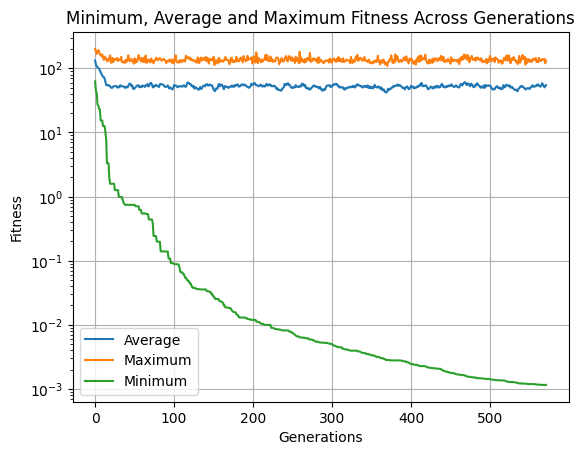

In [14]:
inf_lim = -5.12
sup_lim = 5.12
dim = 10
pop_size = 1000
use_elitism = True

initial_pop = generate_random_initial_pop(inf_lim=inf_lim, sup_lim=sup_lim, dimensions=dim, points=pop_size)
initial_pop_fitness = fitness(initial_pop)

tournament_ga = GeneticAlgorithm(
    NextGenerationProducer(
        TournamentSelector(k=10),
        ArithmeticCrossoverOperator(alpha=0.5),
        NormalMutationOperator(mut_rate=0.2, inf_lim=inf_lim, sup_lim=sup_lim, mean=0.0, std_dev=1.0, dimensions=dim),
        ProportionalNormalMutationOperator(mut_rate=0.8, inf_lim=inf_lim, sup_lim=sup_lim, initial_fitness=np.min(initial_pop_fitness),fitness_callback=fitness, initial_std_dev=1.0, mean=0.0, dimensions=dim),
        preserve_best=use_elitism,
        mutate_best=use_elitism
    ),
    fitness,
    opt_value=np.array([0.0 for _ in range(dim)]),
    max_generations=10000,
    max_gens_without_min_improvement=100,
    max_gens_without_mean_improvement=None,
    min_pop_diversity_std_dev=1e-3,
    precision=1e-6,
)

best_individual = tournament_ga.execute(initial_pop, 1)

print("Best Individual:", best_individual)
print("Fitness:", fitness(best_individual))

plot_run_hist(tournament_ga.gen_fitness_history)

Stopping at iteration 124 because too many iterations (100) were executed without providing a minimal fitness improvement.
Best Individual: [-0.03830526 -1.03868105  0.06682395 -1.97774429 -1.06379847  0.19307574
 -0.09609128 -0.10762187  0.96541682  1.06914334]
Fitness: 22.23378920947009


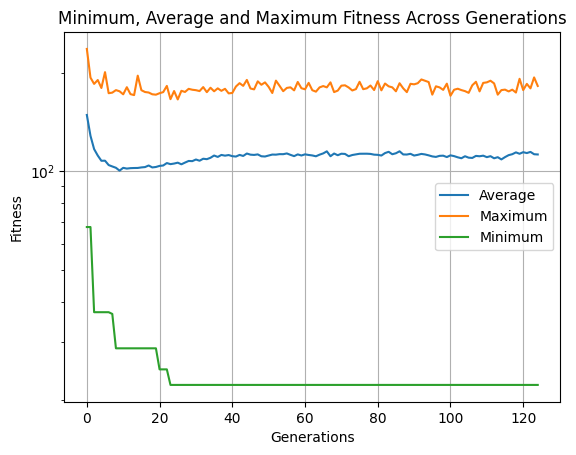

In [15]:
inf_lim = -5.12
sup_lim = 5.12
dim = 10
pop_size = 1000
use_elitism = True

fitness_roulette_ga = GeneticAlgorithm(
    NextGenerationProducer(
        FitnessProportionalRoulette(),
        ArithmeticCrossoverOperator(alpha=0.5),
        NormalMutationOperator(mut_rate=0.2, inf_lim=inf_lim, sup_lim=sup_lim, mean=0.0, std_dev=1.0, dimensions=dim),
        ProportionalNormalMutationOperator(mut_rate=0.8, inf_lim=inf_lim, sup_lim=sup_lim, initial_fitness=np.min(initial_pop_fitness),fitness_callback=fitness, initial_std_dev=1.0, mean=0.0, dimensions=dim),
        preserve_best=use_elitism,
        mutate_best=use_elitism
    ),
    fitness,
    opt_value=np.array([0.0 for _ in range(dim)]),
    max_generations=10000,
    max_gens_without_min_improvement=100,
    max_gens_without_mean_improvement=None,
    min_pop_diversity_std_dev=1e-3,
    precision=1e-6,
)

initial_pop = generate_random_initial_pop(inf_lim=inf_lim, sup_lim=sup_lim, dimensions=dim, points=pop_size)

best_individual = fitness_roulette_ga.execute(initial_pop, True)

print("Best Individual:", best_individual)
print("Fitness:", fitness(best_individual))

plot_run_hist(fitness_roulette_ga.gen_fitness_history)

Stopping at iteration 147 because too many iterations (100) were executed without providing a minimal fitness improvement.
Best Individual: [ 0.00035161  0.00039077 -0.00032299 -0.00029645 -0.00042503 -0.00078427
  0.0004451  -0.00049453  0.00058205 -0.00053835]
Fitness: 0.0004633527992865538


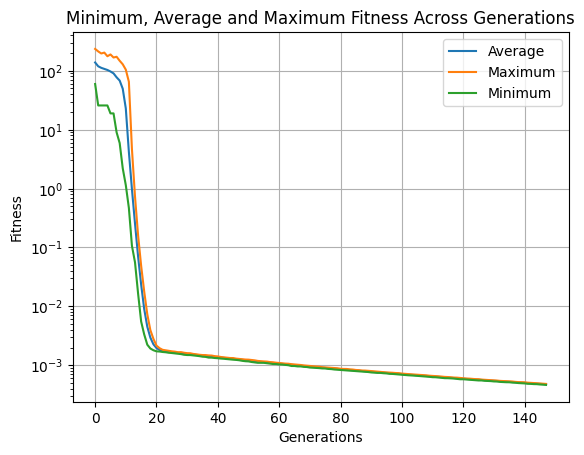

In [16]:
inf_lim = -5.12
sup_lim = 5.12
dim = 10
pop_size = 1000
use_elitism = True

initial_pop = generate_random_initial_pop(inf_lim=inf_lim, sup_lim=sup_lim, dimensions=dim, points=pop_size)
initial_pop_fitness = fitness(initial_pop)

tournament_ga = GeneticAlgorithm(
    NextGenerationProducer(
        TournamentSelector(k=10),
        ArithmeticCrossoverOperator(alpha=0.5),
        ProportionalNormalMutationOperator(mut_rate=0.2, inf_lim=inf_lim, sup_lim=sup_lim, initial_fitness=np.min(initial_pop_fitness),fitness_callback=fitness, initial_std_dev=1.0, mean=0.0, dimensions=dim),
        ProportionalNormalMutationOperator(mut_rate=0.8, inf_lim=inf_lim, sup_lim=sup_lim, initial_fitness=np.min(initial_pop_fitness),fitness_callback=fitness, initial_std_dev=1.0, mean=0.0, dimensions=dim),
        preserve_best=use_elitism,
        mutate_best=use_elitism
    ),
    fitness,
    opt_value=np.array([0.0 for _ in range(dim)]),
    max_generations=10000,
    max_gens_without_min_improvement=100,
    max_gens_without_mean_improvement=None,
    min_pop_diversity_std_dev=None,
    precision=1e-6,
)

best_individual = tournament_ga.execute(initial_pop, 1)

print("Best Individual:", best_individual)
print("Fitness:", fitness(best_individual))

plot_run_hist(tournament_ga.gen_fitness_history)

Stopping at iteration 127 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 48 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 97 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 123 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 158 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 151 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 53 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 108 because too many iterations (25) were executed without providing a minimal fitness improvement.
Stopping at iteration 141 b

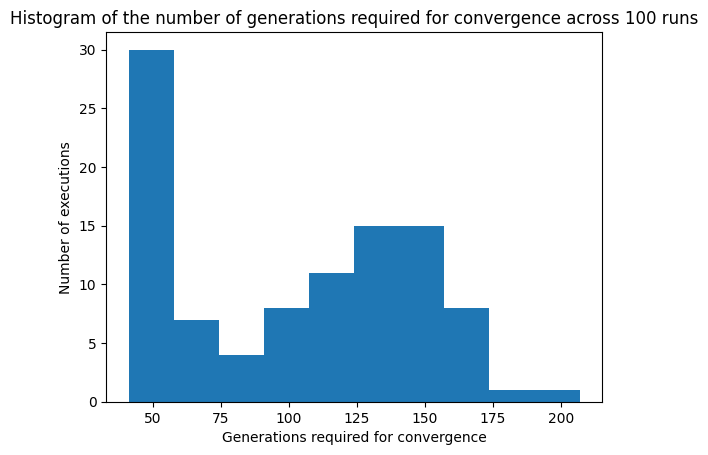

In [ ]:
inf_lim = -5.12
sup_lim = 5.12
dim = 10
pop_size = 1000
use_elitism = True
n_runs = 100

generations_per_run = []

for run_index in range(n_runs):
    initial_pop = generate_random_initial_pop(inf_lim=inf_lim, sup_lim=sup_lim, dimensions=dim, points=pop_size)
    initial_pop_fitness = fitness(initial_pop)

    tournament_ga = GeneticAlgorithm(
        NextGenerationProducer(
            TournamentSelector(k=10),
            ArithmeticCrossoverOperator(alpha=0.5),
            ProportionalNormalMutationOperator(mut_rate=0.2, inf_lim=inf_lim, sup_lim=sup_lim, initial_fitness=np.min(initial_pop_fitness),fitness_callback=fitness, initial_std_dev=1.0, mean=0.0, dimensions=dim),
            ProportionalNormalMutationOperator(mut_rate=0.8, inf_lim=inf_lim, sup_lim=sup_lim, initial_fitness=np.min(initial_pop_fitness),fitness_callback=fitness, initial_std_dev=1.0, mean=0.0, dimensions=dim),
            preserve_best=use_elitism,
            mutate_best=use_elitism
        ),
        fitness,
        opt_value=np.array([0.0 for _ in range(dim)]),
        max_generations=10000,
        max_gens_without_min_improvement=25,
        max_gens_without_mean_improvement=None,
        min_pop_diversity_std_dev=None,
        precision=1e-6,
    )

    best_individual = tournament_ga.execute(initial_pop, 1)
    generations_per_run.append(len(tournament_ga.gen_fitness_history))

plot_run_histogram(generations_per_run)

## 5 Conlcusão

O modelo que minimiza o MSE do conjunto de teste é 6, significa que o modelo com seis características específicas resulta em um desempenho preditivo mais eficaz em relação ao conjunto de teste. Isso é uma indicação de que incluir essas seis características específicas é mais benéfico para a generalização do modelo em dados não vistos.

O MSE mínimo do conjunto de teste é 0.9599, indicando que, em média, os quadrados dos erros de previsão são relativamente baixos, o que é positivo. Esses resultados sugerem que o modelo com seis características está equilibrando efetivamente o viés e a variância, resultando em um desempenho geral melhor.

## 6 Referências Bibliográficas

[1] A. E. Eiben and J. E. Smith, Introduction to evolutionary computing. Springer, 2015.

[2] L. A. Rastrigin, “Systems of extremal control,” in Theoretical Foundations of
Engineering Cybernetics Series, Moscow: Nauka, 1974.